In [ ]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
#hide
from fastbook import *

# The Training Process

You now know how to create state-of-the-art architectures for computer vision, natural language processing, tabular analysis, and collaborative filtering, and you know how to train them quickly. So we're done, right? Not quite yet. We still have to explore a little bit more the training process.

We explained in <<chapter_mnist_basics>> the basis of stochastic gradient descent: pass a mini-batch to the model, compare it to our target with the loss function, then compute the gradients of this loss function with regard to each weight before updating the weights with the formula:

```python
new_weight = weight - lr * weight.grad
```

We implemented this from scratch in a training loop, and also saw that PyTorch provides a simple `nn.SGD` class that does this calculation for each parameter for us. In this chapter we will build some faster optimizers, using a flexible foundation. But that's not all we might want to change in the training process. For any tweak of the training loop, we will need a way to add some code to the basis of SGD. The fastai library has a system of callbacks to do this, and we will teach you all about it.

Let's start with standard SGD to get a baseline, then we will introduce the most commonly used optimizers.

## Establishing a Baseline

First, we'll create a baseline, using plain SGD, and compare it to fastai's default optimizer. We'll start by grabbing Imagenette with the same `get_data` we used in <<chapter_resnet>>:

In [ ]:
#hide_input
def get_data(url, presize, resize):
    path = untar_data(url)
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock), get_items=get_image_files, 
        splitter=GrandparentSplitter(valid_name='val'),
        get_y=parent_label, item_tfms=Resize(presize),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                    Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs=128)

In [ ]:
dls = get_data(URLs.IMAGENETTE_160, 160, 128)

We'll create a ResNet-34 without pretraining, and pass along any arguments received:

In [ ]:
def get_learner(**kwargs):
    return vision_learner(dls, resnet34, pretrained=False,
                    metrics=accuracy, **kwargs).to_fp16()

Here's the default fastai optimizer, with the usual 3e-3 learning rate:

In [ ]:
learn = get_learner()
learn.fit_one_cycle(3, 0.003)

epoch,train_loss,valid_loss,accuracy,time
0,2.571932,2.685040,0.322548,00:11
1,1.904674,1.852589,0.437452,00:11
2,1.586909,1.374908,0.594904,00:11


Now let's try plain SGD. We can pass `opt_func` (optimization function) to `vision_learner` to get fastai to use any optimizer:

In [ ]:
learn = get_learner(opt_func=SGD)

The first thing to look at is `lr_find`:

(0.017378008365631102, 3.019951861915615e-07)

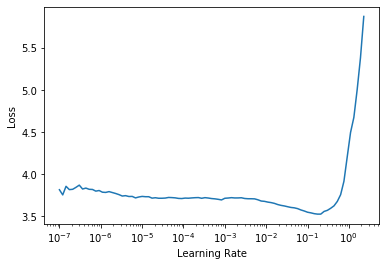

In [ ]:
learn.lr_find()

It looks like we'll need to use a higher learning rate than we normally use:

In [ ]:
learn.fit_one_cycle(3, 0.03, moms=(0,0,0))

epoch,train_loss,valid_loss,accuracy,time
0,2.969412,2.214596,0.242038,00:09
1,2.442730,1.845950,0.362548,00:09
2,2.157159,1.741143,0.408917,00:09


Because accelerating SGD with momentum is such a good idea, fastai does this by default in `fit_one_cycle`, so we turn it off with `moms=(0,0,0)`. We'll be discussing momentum shortly.)

Clearly, plain SGD isn't training as fast as we'd like. So let's learn some tricks to get accelerated training!

## A Generic Optimizer

To build up our accelerated SGD tricks, we'll need to start with a nice flexible optimizer foundation. No library prior to fastai provided such a foundation, but during fastai's development we realized that all the optimizer improvements we'd seen in the academic literature could be handled using *optimizer callbacks*. These are small pieces of code that we can compose, mix and match in an optimizer to build the optimizer `step`. They are called by fastai's lightweight `Optimizer` class. These are the definitions in `Optimizer` of the two key methods that we've been using in this book:

```python
def zero_grad(self):
    for p,*_ in self.all_params():
        p.grad.detach_()
        p.grad.zero_()

def step(self):
    for p,pg,state,hyper in self.all_params():
        for cb in self.cbs:
            state = _update(state, cb(p, **{**state, **hyper}))
        self.state[p] = state
```

As we saw when training an MNIST model from scratch, `zero_grad` just loops through the parameters of the model and sets the gradients to zero. It also calls `detach_`, which removes any history of gradient computation, since it won't be needed after `zero_grad`.

The more interesting method is `step`, which loops through the callbacks (`cbs`) and calls them to update the parameters (the `_update` function just calls `state.update` if there's anything returned by `cb`). As you can see, `Optimizer` doesn't actually do any SGD steps itself. Let's see how we can add SGD to `Optimizer`.

Here's an optimizer callback that does a single SGD step, by multiplying `-lr` by the gradients and adding that to the parameter (when `Tensor.add_` in PyTorch is passed two parameters, they are multiplied together before the addition): 

In [ ]:
def sgd_cb(p, lr, **kwargs): p.data.add_(-lr, p.grad.data)

We can pass this to `Optimizer` using the `cbs` parameter; we'll need to use `partial` since `Learner` will call this function to create our optimizer later:

In [ ]:
opt_func = partial(Optimizer, cbs=[sgd_cb])

Let's see if this trains:

In [ ]:
learn = get_learner(opt_func=opt_func)
learn.fit(3, 0.03)

epoch,train_loss,valid_loss,accuracy,time
0,2.730918,2.009971,0.332739,00:09
1,2.204893,1.747202,0.441529,00:09
2,1.875621,1.684515,0.445350,00:09


It's working! So that's how we create SGD from scratch in fastai. Now let's see what "momentum" is.

## Momentum

As described in <<chapter_mnist_basics>>, SGD can be thought of as standing at the top of a mountain and working your way down by taking a step in the direction of the steepest slope at each point in time. But what if we have a ball rolling down the mountain? It won't, at each given point, exactly follow the direction of the gradient, as it will have *momentum*. A ball with more momentum (for instance, a heavier ball) will skip over little bumps and holes, and be more likely to get to the bottom of a bumpy mountain. A ping pong ball, on the other hand, will get stuck in every little crevice.

So how can we bring this idea over to SGD? We can use a moving average, instead of only the current gradient, to make our step:

```python
weight.avg = beta * weight.avg + (1-beta) * weight.grad
new_weight = weight - lr * weight.avg
```

Here `beta` is some number we choose which defines how much momentum to use. If `beta` is 0, then the first equation becomes  `weight.avg = weight.grad`, so we end up with plain SGD. But if it's a number close to 1, then the main direction chosen is an average of the previous steps. (If you have done a bit of statistics, you may recognize in the first equation an *exponentially weighted moving average*, which is very often used to denoise data and get the underlying tendency.)

Note that we are writing `weight.avg` to highlight the fact that we need to store the moving averages for each parameter of the model (they all have their own independent moving averages).

<<img_momentum>> shows an example of noisy data for a single parameter, with the momentum curve plotted in red, and the gradients of the parameter plotted in blue. The gradients increase, then decrease, and the momentum does a good job of following the general trend without getting too influenced by noise.

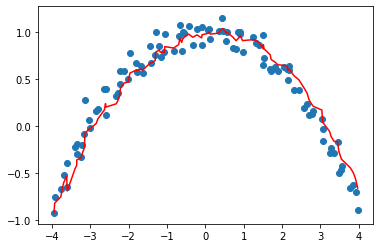

In [ ]:
#hide_input
#id img_momentum
#caption An example of momentum
#alt Graph showing an example of momentum
x = np.linspace(-4, 4, 100)
y = 1 - (x/3) ** 2
x1 = x + np.random.randn(100) * 0.1
y1 = y + np.random.randn(100) * 0.1
plt.scatter(x1,y1)
idx = x1.argsort()
beta,avg,res = 0.7,0,[]
for i in idx:
    avg = beta * avg + (1-beta) * y1[i]
    res.append(avg/(1-beta**(i+1)))
plt.plot(x1[idx],np.array(res), color='red');

It works particularly well if the loss function has narrow canyons we need to navigate: vanilla SGD would send us bouncing from one side to the other, while SGD with momentum will average those to roll smoothly down the side. The parameter `beta` determines the strength of the momentum we are using: with a small `beta` we stay closer to the actual gradient values, whereas with a high `beta` we will mostly go in the direction of the average of the gradients and it will take a while before any change in the gradients makes that trend move.

With a large `beta`, we might miss that the gradients have changed directions and roll over a small local minima. This is a desired side effect: intuitively, when we show a new input to our model, it will look like something in the training set but won't be *exactly* like it. That means it will correspond to a point in the loss function that is close to the minimum we ended up with at the end of training, but not exactly *at* that minimum. So, we would rather end up training in a wide minimum, where nearby points have approximately the same loss (or if you prefer, a point where the loss is as flat as possible). <<img_betas>> shows how the chart in <<img_momentum>> varies as we change `beta`.

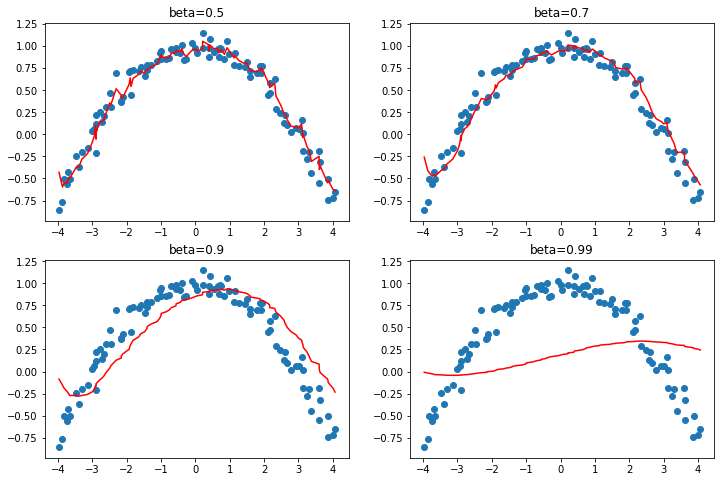

In [ ]:
#hide_input
#id img_betas
#caption Momentum with different beta values
#alt Graph showing how the beta value influences momentum
x = np.linspace(-4, 4, 100)
y = 1 - (x/3) ** 2
x1 = x + np.random.randn(100) * 0.1
y1 = y + np.random.randn(100) * 0.1
_,axs = plt.subplots(2,2, figsize=(12,8))
betas = [0.5,0.7,0.9,0.99]
idx = x1.argsort()
for beta,ax in zip(betas, axs.flatten()):
    ax.scatter(x1,y1)
    avg,res = 0,[]
    for i in idx:
        avg = beta * avg + (1-beta) * y1[i]
        res.append(avg)#/(1-beta**(i+1)))
    ax.plot(x1[idx],np.array(res), color='red');
    ax.set_title(f'beta={beta}')

We can see in these examples that a `beta` that's too high results in the overall changes in gradient getting ignored. In SGD with momentum, a value of `beta` that is often used is 0.9.

`fit_one_cycle` by default starts with a `beta` of 0.95, gradually adjusts it to 0.85, and then gradually moves it back to 0.95 at the end of training. Let's see how our training goes with momentum added to plain SGD.

In order to add momentum to our optimizer, we'll first need to keep track of the moving average gradient, which we can do with another callback. When an optimizer callback returns a `dict`, it is used to update the state of the optimizer and is passed back to the optimizer on the next step. So this callback will keep track of the gradient averages in a parameter called `grad_avg`:

In [ ]:
def average_grad(p, mom, grad_avg=None, **kwargs):
    if grad_avg is None: grad_avg = torch.zeros_like(p.grad.data)
    return {'grad_avg': grad_avg*mom + p.grad.data}

To use it, we just have to replace `p.grad.data` with `grad_avg` in our step function:

In [ ]:
def momentum_step(p, lr, grad_avg, **kwargs): p.data.add_(-lr, grad_avg)

In [ ]:
opt_func = partial(Optimizer, cbs=[average_grad,momentum_step], mom=0.9)

`Learner` will automatically schedule `mom` and `lr`, so `fit_one_cycle` will even work with our custom `Optimizer`:

In [ ]:
learn = get_learner(opt_func=opt_func)
learn.fit_one_cycle(3, 0.03)

epoch,train_loss,valid_loss,accuracy,time
0,2.856000,2.493429,0.246115,00:10
1,2.504205,2.463813,0.348280,00:10
2,2.187387,1.755670,0.418853,00:10


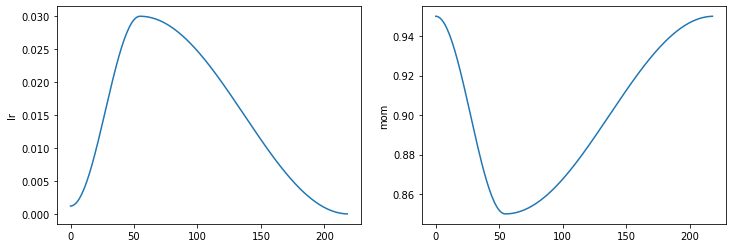

In [ ]:
learn.recorder.plot_sched()

We're still not getting great results, so let's see what else we can do.

## RMSProp

RMSProp is another variant of SGD introduced by Geoffrey Hinton in Lecture 6e of his Coursera class ["Neural Networks for Machine Learning"](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf). The main difference from SGD is that it uses an adaptive learning rate: instead of using the same learning rate for every parameter, each parameter gets its own specific learning rate controlled by a global learning rate. That way we can speed up training by giving a higher learning rate to the weights that need to change a lot while the ones that are good enough get a lower learning rate.

How do we decide which parameters should have a high learning rate and which should not? We can look at the gradients to get an idea. If a parameter's gradients have been close to zero for a while, that parameter will need a higher learning rate because the loss is flat. On the other hand, if the gradients are all over the place, we should probably be careful and pick a low learning rate to avoid divergence. We can't just average the gradients to see if they're changing a lot, because the average of a large positive and a large negative number is close to zero. Instead, we can use the usual trick of either taking the absolute value or the squared values (and then taking the square root after the mean).

Once again, to determine the general tendency behind the noise, we will use a moving average—specifically the moving average of the gradients squared. Then we will update the corresponding weight by using the current gradient (for the direction) divided by the square root of this moving average (that way if it's low, the effective learning rate will be higher, and if it's high, the effective learning rate will be lower):

```python
w.square_avg = alpha * w.square_avg + (1-alpha) * (w.grad ** 2)
new_w = w - lr * w.grad / math.sqrt(w.square_avg + eps)
```

The `eps` (*epsilon*) is added for numerical stability (usually set at 1e-8), and the default value for `alpha` is usually 0.99.

We can add this to `Optimizer` by doing much the same thing we did for `avg_grad`, but with an extra `**2`:

In [ ]:
def average_sqr_grad(p, sqr_mom, sqr_avg=None, **kwargs):
    if sqr_avg is None: sqr_avg = torch.zeros_like(p.grad.data)
    return {'sqr_avg': sqr_mom*sqr_avg + (1-sqr_mom)*p.grad.data**2}

And we can define our step function and optimizer as before:

In [ ]:
def rms_prop_step(p, lr, sqr_avg, eps, grad_avg=None, **kwargs):
    denom = sqr_avg.sqrt().add_(eps)
    p.data.addcdiv_(-lr, p.grad, denom)

opt_func = partial(Optimizer, cbs=[average_sqr_grad,rms_prop_step],
                   sqr_mom=0.99, eps=1e-7)

Let's try it out:

In [ ]:
learn = get_learner(opt_func=opt_func)
learn.fit_one_cycle(3, 0.003)

epoch,train_loss,valid_loss,accuracy,time
0,2.766912,1.845900,0.402548,00:11
1,2.194586,1.510269,0.504459,00:11
2,1.869099,1.447939,0.544968,00:11


Much better! Now we just have to bring these ideas together, and we have Adam, fastai's default optimizer.

## Adam

Adam mixes the ideas of SGD with momentum and RMSProp together: it uses the moving average of the gradients as a direction and divides by the square root of the moving average of the gradients squared to give an adaptive learning rate to each parameter.

There is one other difference in how Adam calculates moving averages. It takes the *unbiased* moving average, which is:

``` python
w.avg = beta * w.avg + (1-beta) * w.grad
unbias_avg = w.avg / (1 - (beta**(i+1)))
```

if we are the `i`-th iteration (starting at 0 like Python does). This divisor of `1 - (beta**(i+1))` makes sure the unbiased average looks more like the gradients at the beginning (since `beta < 1`, the denominator is very quickly close to 1).

Putting everything together, our update step looks like:
``` python
w.avg = beta1 * w.avg + (1-beta1) * w.grad
unbias_avg = w.avg / (1 - (beta1**(i+1)))
w.sqr_avg = beta2 * w.sqr_avg + (1-beta2) * (w.grad ** 2)
new_w = w - lr * unbias_avg / sqrt(w.sqr_avg + eps)
```

Like for RMSProp, `eps` is usually set to 1e-8, and the default for `(beta1,beta2)` suggested by the literature is `(0.9,0.999)`. 

In fastai, Adam is the default optimizer we use since it allows faster training, but we've found that `beta2=0.99` is better suited to the type of schedule we are using. `beta1` is the momentum parameter, which we specify with the argument `moms` in our call to `fit_one_cycle`. As for `eps`, fastai uses a default of 1e-5. `eps` is not just useful for numerical stability. A higher `eps` limits the maximum value of the adjusted learning rate. To take an extreme example, if `eps` is 1, then the adjusted learning will never be higher than the base learning rate. 

Rather than show all the code for this in the book, we'll let you look at the optimizer notebook in [fastai's GitHub repository](https://github.com/fastai/fastai) (browse the *nbs* folder and search for the notebook called optimizer). You'll see all the code we've shown so far, along with Adam and other optimizers, and lots of examples and tests.

One thing that changes when we go from SGD to Adam is the way we apply weight decay, and it can have important consequences.

## Decoupled Weight Decay

Weight decay, which we discussed in <<chapter_collab>>, is equivalent to (in the case of vanilla SGD) updating the parameters
with:

``` python
new_weight = weight - lr*weight.grad - lr*wd*weight
```

The last part of this formula explains the name of this technique: each weight is decayed by a factor `lr * wd`. 

The other name of weight decay is L2 regularization, which consists in adding the sum of all squared weights to the loss (multiplied by the weight decay). As we have seen in <<chapter_collab>>, this can be directly expressed on the gradients with:

``` python
weight.grad += wd*weight
```

For SGD, those two formulas are equivalent. However, this equivalence only holds for standard SGD, because we have seen that with momentum, RMSProp or in Adam, the update has some additional formulas around the gradient. 

Most libraries use the second formulation, but it was pointed out in ["Decoupled Weight Decay Regularization"](https://arxiv.org/pdf/1711.05101.pdf) by Ilya Loshchilov and Frank Hutter, that the first one is the only correct approach with the Adam optimizer or momentum, which is why fastai makes it its default.

Now you know everything that is hidden behind the line `learn.fit_one_cycle`!

Optimizers are only one part of the training process, however when you need to change the training loop with fastai, you can't directly change the code inside the library. Instead, we have designed a system of callbacks to let you write any tweaks you like in independent blocks that you can then mix and match. 

## Callbacks

Sometimes you need to change how things work a little bit. In fact, we have already seen examples of this: Mixup, fp16 training, resetting the model after each epoch for training RNNs, and so forth. How do we go about making these kinds of tweaks to the training process?

We've seen the basic training loop, which, with the help of the `Optimizer` class, looks like this for a single epoch:

```python
for xb,yb in dl:
    loss = loss_func(model(xb), yb)
    loss.backward()
    opt.step()
    opt.zero_grad()
```

<<basic_loop>> shows how to picture that.

<img alt="Basic training loop" width="300" caption="Basic training loop" id="basic_loop" src="images/att_00048.png">

The usual way for deep learning practitioners to customize the training loop is to make a copy of an existing training loop, and then insert the code necessary for their particular changes into it. This is how nearly all code that you find online will look. But it has some very serious problems.

It's not very likely that some particular tweaked training loop is going to meet your particular needs. There are hundreds of changes that can be made to a training loop, which means there are billions and billions of possible permutations. You can't just copy one tweak from a training loop here, another from a training loop there, and expect them all to work together. Each will be based on different assumptions about the environment that it's working in, use different naming conventions, and expect the data to be in different formats.

We need a way to allow users to insert their own code at any part of the training loop, but in a consistent and well-defined way. Computer scientists have already come up with an elegant solution: the callback. A callback is a piece of code that you write, and inject into another piece of code at some predefined point. In fact, callbacks have been used with deep learning training loops for years. The problem is that in previous libraries it was only possible to inject code in a small subset of places where this may have been required, and, more importantly, callbacks were not able to do all the things they needed to do.

In order to be just as flexible as manually copying and pasting a training loop and directly inserting code into it, a callback must be able to read every possible piece of information available in the training loop, modify all of it as needed, and fully control when a batch, epoch, or even the whole training loop should be terminated. fastai is the first library to provide all of this functionality. It modifies the training loop so it looks like <<cb_loop>>.

<img alt="Training loop with callbacks" width="550" caption="Training loop with callbacks" id="cb_loop" src="images/att_00049.png">

The real effectiveness of this approach has been borne out over the last couple of years—it has turned out that, by using the fastai callback system, we were able to implement every single new paper we tried and fulfilled every user request for modifying the training loop. The training loop itself has not required modifications. <<some_cbs>> shows just a few of the callbacks that have been added.

<img alt="Some fastai callbacks" width="500" caption="Some fastai callbacks" id="some_cbs" src="images/att_00050.png">

The reason that this is important is because it means that whatever idea we have in our head, we can implement it. We need never dig into the source code of PyTorch or fastai and hack together some one-off system to try out our ideas. And when we do implement our own callbacks to develop our own ideas, we know that they will work together with all of the other functionality provided by fastai–so we will get progress bars, mixed-precision training, hyperparameter annealing, and so forth.

Another advantage is that it makes it easy to gradually remove or add functionality and perform ablation studies. You just need to adjust the list of callbacks you pass along to your fit function.

As an example, here is the fastai source code that is run for each batch of the training loop:

```python
try:
    self._split(b);                                  self('before_batch')
    self.pred = self.model(*self.xb);                self('after_pred')
    self.loss = self.loss_func(self.pred, *self.yb); self('after_loss')
    if not self.training: return
    self.loss.backward();                            self('after_backward')
    self.opt.step();                                 self('after_step')
    self.opt.zero_grad()
except CancelBatchException:                         self('after_cancel_batch')
finally:                                             self('after_batch')
```

The calls of the form `self('...')` are where the callbacks are called. As you see, this happens after every step. The callback will receive the entire state of training, and can also modify it. For instance, the input data and target labels are in `self.xb` and `self.yb`, respectively; a callback can modify these to alter the data the training loop sees. It can also modify `self.loss`, or even the gradients.

Let's see how this works in practice by writing a callback.

### Creating a Callback

When you want to write your own callback, the full list of available events is:

- `before_fit`:: called before doing anything; ideal for initial setup.
- `before_epoch`:: called at the beginning of each epoch; useful for any behavior you need to reset at each epoch.
- `before_train`:: called at the beginning of the training part of an epoch.
- `before_batch`:: called at the beginning of each batch, just after drawing said batch. It can be used to do any setup necessary for the batch (like hyperparameter scheduling) or to change the input/target before it goes into the model (for instance, apply Mixup).
- `after_pred`:: called after computing the output of the model on the batch. It can be used to change that output before it's fed to the loss function.
- `after_loss`:: called after the loss has been computed, but before the backward pass. It can be used to add penalty to the loss (AR or TAR in RNN training, for instance).
- `after_backward`:: called after the backward pass, but before the update of the parameters. It can be used to make changes to the gradients before said update (via gradient clipping, for instance).
- `after_step`:: called after the step and before the gradients are zeroed.
- `after_batch`:: called at the end of a batch, to perform any required cleanup before the next one.
- `after_train`:: called at the end of the training phase of an epoch.
- `before_validate`:: called at the beginning of the validation phase of an epoch; useful for any setup needed specifically for validation.
- `after_validate`:: called at the end of the validation part of an epoch.
- `after_epoch`:: called at the end of an epoch, for any cleanup before the next one.
- `after_fit`:: called at the end of training, for final cleanup.

The elements of this list are available as attributes of the special variable `event`, so you can just type `event.` and hit Tab in your notebook to see a list of all the options.

Let's take a look at an example. Do you recall how in <<chapter_nlp_dive>> we needed to ensure that our special `reset` method was called at the start of training and validation for each epoch? We used the `ModelResetter` callback provided by fastai to do this for us. But how does it work? Here's the full source code for that class:

In [ ]:
class ModelResetter(Callback):
    def before_train(self):    self.model.reset()
    def before_validate(self): self.model.reset()

Yes, that's actually it! It just does what we said in the preceding paragraph: after completing training or validation for an epoch, call a method named `reset`.

Callbacks are often "short and sweet" like this one. In fact, let's look at one more. Here's the fastai source for the callback that adds RNN regularization (AR and TAR):

In [ ]:
class RNNRegularizer(Callback):
    def __init__(self, alpha=0., beta=0.): self.alpha,self.beta = alpha,beta

    def after_pred(self):
        self.raw_out,self.out = self.pred[1],self.pred[2]
        self.learn.pred = self.pred[0]

    def after_loss(self):
        if not self.training: return
        if self.alpha != 0.:
            self.learn.loss += self.alpha * self.out[-1].float().pow(2).mean()
        if self.beta != 0.:
            h = self.raw_out[-1]
            if len(h)>1:
                self.learn.loss += self.beta * (h[:,1:] - h[:,:-1]
                                               ).float().pow(2).mean()

> note: Code It Yourself: Go back and reread "Activation Regularization and Temporal Activation Regularization" in <<chapter_nlp_dive>> then take another look at the code here. Make sure you understand what it's doing, and why.

In both of these examples, notice how we can access attributes of the training loop by directly checking `self.model` or `self.pred`. That's because a `Callback` will always try to get an attribute it doesn't have inside the `Learner` associated with it. These are shortcuts for `self.learn.model` or `self.learn.pred`. Note that they work for reading attributes, but not for writing them, which is why when `RNNRegularizer` changes the loss or the predictions you see `self.learn.loss = ` or `self.learn.pred = `. 

When writing a callback, the following attributes of `Learner` are available:

- `model`:: The model used for training/validation.
- `data`:: The underlying `DataLoaders`.
- `loss_func`:: The loss function used.
- `opt`:: The optimizer used to update the model parameters.
- `opt_func`:: The function used to create the optimizer.
- `cbs`:: The list containing all the `Callback`s.
- `dl`:: The current `DataLoader` used for iteration.
- `x`/`xb`:: The last input drawn from `self.dl` (potentially modified by callbacks). `xb` is always a tuple (potentially with one element) and `x` is detuplified. You can only assign to `xb`.
- `y`/`yb`:: The last target drawn from `self.dl` (potentially modified by callbacks). `yb` is always a tuple (potentially with one element) and `y` is detuplified. You can only assign to `yb`.
- `pred`:: The last predictions from `self.model` (potentially modified by callbacks).
- `loss`:: The last computed loss (potentially modified by callbacks).
- `n_epoch`:: The number of epochs in this training.
- `n_iter`:: The number of iterations in the current `self.dl`.
- `epoch`:: The current epoch index (from 0 to `n_epoch-1`).
- `iter`:: The current iteration index in `self.dl` (from 0 to `n_iter-1`).

The following attributes are added by `TrainEvalCallback` and should be available unless you went out of your way to remove that callback:

- `train_iter`:: The number of training iterations done since the beginning of this training
- `pct_train`:: The percentage of training iterations completed (from 0. to 1.)
- `training`:: A flag to indicate whether or not we're in training mode

The following attribute is added by `Recorder` and should be available unless you went out of your way to remove that callback:

- `smooth_loss`:: An exponentially averaged version of the training loss

Callbacks can also interrupt any part of the training loop by using a system of exceptions.

### Callback Ordering and Exceptions

Sometimes, callbacks need to be able to tell fastai to skip over a batch, or an epoch, or stop training altogether. For instance, consider `TerminateOnNaNCallback`. This handy callback will automatically stop training any time the loss becomes infinite or `NaN` (*not a number*). Here's the fastai source for this callback:

In [ ]:
class TerminateOnNaNCallback(Callback):
    run_before=Recorder
    def after_batch(self):
        if torch.isinf(self.loss) or torch.isnan(self.loss):
            raise CancelFitException

The line `raise CancelFitException` tells the training loop to interrupt training at this point. The training loop catches this exception and does not run any further training or validation. The callback control flow exceptions available are:

- `CancelBatchException`:: Skip the rest of this batch and go to `after_batch`.
- `CancelTrainException`:: Skip the rest of the training part of the epoch and go to `after_train`.
- `CancelValidException`:: Skip the rest of the validation part of the epoch and go to `after_validate`.
- `CancelEpochException`:: Skip the rest of this epoch and go to `after_epoch`.
- `CancelFitException`:: Interrupt training and go to `after_fit`.

You can detect if one of those exceptions has occurred and add code that executes right after with the following events:

- `after_cancel_batch`:: Reached immediately after a `CancelBatchException` before proceeding to `after_batch`
- `after_cancel_train`:: Reached immediately after a `CancelTrainException` before proceeding to `after_train`
- `after_cancel_valid`:: Reached immediately after a `CancelValidException` before proceeding to `after_valid`
- `after_cancel_epoch`:: Reached immediately after a `CancelEpochException` before proceeding to `after_epoch`
- `after_cancel_fit`:: Reached immediately after a `CancelFitException` before proceeding to `after_fit`

Sometimes, callbacks need to be called in a particular order. For example, in the case of `TerminateOnNaNCallback`, it's important that `Recorder` runs its `after_batch` after this callback, to avoid registering an `NaN` loss. You can specify `run_before` (this callback must run before ...) or `run_after` (this callback must run after ...) in your callback to ensure the ordering that you need.

## Conclusion

In this chapter we took a close look at the training loop, exploring different variants of SGD and why they can be more powerful. At the time of writing, developing new optimizers is a very active area of research, so by the time you read this chapter there may be an addendum on the book's website that presents new variants. Be sure to check out how our general optimizer framework can help you implement new optimizers very quickly.

We also examined the powerful callback system that allows you to customize every bit of the training loop by enabling you to inspect and modify any parameter you like between each step.

## Questionnaire

1. What is the equation for a step of SGD, in math or code (as you prefer)?
1. What do we pass to `vision_learner` to use a non-default optimizer?
1. What are optimizer callbacks?
1. What does `zero_grad` do in an optimizer?
1. What does `step` do in an optimizer? How is it implemented in the general optimizer?
1. Rewrite `sgd_cb` to use the `+=` operator, instead of `add_`.
1. What is "momentum"? Write out the equation.
1. What's a physical analogy for momentum? How does it apply in our model training settings?
1. What does a bigger value for momentum do to the gradients?
1. What are the default values of momentum for 1cycle training?
1. What is RMSProp? Write out the equation.
1. What do the squared values of the gradients indicate?
1. How does Adam differ from momentum and RMSProp?
1. Write out the equation for Adam.
1. Calculate the values of `unbias_avg` and `w.avg` for a few batches of dummy values.
1. What's the impact of having a high `eps` in Adam?
1. Read through the optimizer notebook in fastai's repo, and execute it.
1. In what situations do dynamic learning rate methods like Adam change the behavior of weight decay?
1. What are the four steps of a training loop?
1. Why is using callbacks better than writing a new training loop for each tweak you want to add?
1. What aspects of the design of fastai's callback system make it as flexible as copying and pasting bits of code?
1. How can you get the list of events available to you when writing a callback?
1. Write the `ModelResetter` callback (without peeking).
1. How can you access the necessary attributes of the training loop inside a callback? When can you use or not use the shortcuts that go with them?
1. How can a callback influence the control flow of the training loop?
1. Write the `TerminateOnNaN` callback (without peeking, if possible).
1. How do you make sure your callback runs after or before another callback?

### Further Research

1. Look up the "Rectified Adam" paper, implement it using the general optimizer framework, and try it out. Search for other recent optimizers that work well in practice, and pick one to implement.
1. Look at the mixed-precision callback with the documentation. Try to understand what each event and line of code does.
1. Implement your own version of the learning rate finder from scratch. Compare it with fastai's version.
1. Look at the source code of the callbacks that ship with fastai. See if you can find one that's similar to what you're looking to do, to get some inspiration.

## Foundations of Deep Learning: Wrap up

Congratulations, you have made it to the end of the "foundations of deep learning" section of the book! You now understand how all of fastai's applications and most important architectures are built, and the recommended ways to train them—and you have all the information you need to build these from scratch. While you probably won't need to create your own training loop, or batchnorm layer, for instance, knowing what is going on behind the scenes is very helpful for debugging, profiling, and deploying your solutions.

Since you understand the foundations of fastai's applications now, be sure to spend some time digging through the source notebooks and running and experimenting with parts of them. This will give you a better idea of how everything in fastai is developed.

In the next section, we will be looking even further under the covers: we'll explore how the actual forward and backward passes of a neural network are done, and we will see what tools are at our disposal to get better performance. We will then continue with a project that brings together all the material in the book, which we will use to build a tool for interpreting convolutional neural networks. Last but not least, we'll finish by building fastai's `Learner` class from scratch.